In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from small2DNet import small2DNet
from util import add_color, colorize, colorize_gaussian, calculate_correct_loss
from colorMNist import colorMNist
import random
import colorsys
import pickle

In [ ]:
# Load data
mnist_train = torchvision.datasets.MNIST('datasets/mnist', train=True, download=False, transform=torchvision.transforms.Compose([
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Lambda(add_color),
                                                    # torchvision.transforms.Normalize(
                                                    #     [0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
                                                    ]))
mnist_test = torchvision.datasets.MNIST('datasets/mnist', train=False, download=False, transform=torchvision.transforms.Compose([
                                                    torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Lambda(add_color),
                                                    # torchvision.transforms.Normalize(
                                                    #     [0.1307, 0.1307, 0.1307], [0.3081, 0.3081, 0.3081])
                                                    ]))

In [3]:
for std in [0, 12, 60, 120, 1000000]:
    print(std)
    gaussian_dict = {0: 0, 1: 36, 2: 72, 3: 108, 4: 144, 5: 180, 6: 216, 7: 252, 8: 288, 9: 324, 10: std}
    color_dict = gaussian_dict
    if std == 0:
        strstd = "cmnist_deterministic"
    elif std == 1000000:
        strstd = "cmnist_gaussian_uniform"
    else:
        strstd = "cmnist_gaussian_" + str(std)

    for j in tqdm([1, 2, 5, 10, 20, 60], total=6, desc="Generating Datasets"):    
        # The filtered dataset
        trimmed_dataset = torch.utils.data.Subset(mnist_train, range(int(j) * 1000))

        # Filtered test dataset
        test_dataset = torch.utils.data.Subset(mnist_test, range(len(mnist_test)))

        # Create the 80/20 train/val split
        train_split = int(0.8 * len(trimmed_dataset))
        # Train dataset
        train_dataset = torch.utils.data.Subset(trimmed_dataset, [i for i in range(train_split)])
        # Validation dataset
        val_dataset = torch.utils.data.Subset(trimmed_dataset, [i for i in range(train_split, len(trimmed_dataset))])

        colormnist_train = []
        colormnist_val = []
        colormnist_test = []

        for x in train_dataset:
            image = x[0]
            label = x[1]

            image, color = colorize_gaussian(image, label, color_dict)
            colormnist_train.append([image, label])

        colormnist_val = []
        for x in val_dataset:
            image = x[0]
            label = x[1]

            image, color = colorize_gaussian(image, label, color_dict)
            colormnist_val.append([image, label])

        colormnist_test = []
        for x in test_dataset:
            image = x[0]
            label = x[1]

            image, color = colorize_gaussian(image, label, color_dict)
            colormnist_test.append([image, label])

        pickle.dump([colormnist_train, colormnist_val, colormnist_test], open("custom_datasets/" + str(j) + "k/" + strstd + ".pkl", "wb"))

0


Generating Datasets: 100%|██████████| 6/6 [01:12<00:00, 12.11s/it]


12


Generating Datasets: 100%|██████████| 6/6 [01:14<00:00, 12.49s/it]


60


Generating Datasets: 100%|██████████| 6/6 [01:17<00:00, 12.86s/it]


120


Generating Datasets: 100%|██████████| 6/6 [01:14<00:00, 12.50s/it]


1000000


Generating Datasets: 100%|██████████| 6/6 [01:15<00:00, 12.65s/it]


In [15]:
cmnist_train, cmnist_val, cmnist_test = pickle.load(open("custom_datasets/2k/cmnist_gaussian_uniform.pkl", "rb"))
cmnist_tr = colorMNist(cmnist_train)
cmnist_va = colorMNist(cmnist_val)
cmnist_te = colorMNist(cmnist_test)
train_dataloader = torch.utils.data.DataLoader(cmnist_tr, batch_size=32, shuffle=False, num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(cmnist_va, batch_size=32, shuffle=False, num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(cmnist_te, batch_size=32, shuffle=False, num_workers = 0)
print("Train dataset length:", len(cmnist_tr))
print("Val dataset length:", len(cmnist_va))
print("Test dataset length:", len(cmnist_te))
print("Total length:", len(cmnist_tr) + len(cmnist_va))

Train dataset length: 1600
Val dataset length: 400
Test dataset length: 10000
Total length: 2000


  0%|          | 0/50 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


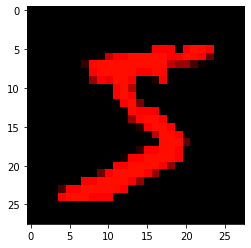

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


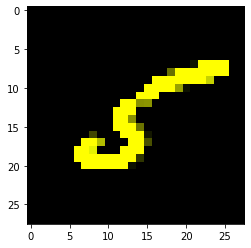

  2%|▏         | 1/50 [00:00<00:07,  6.15it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


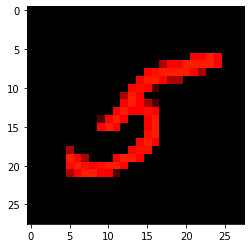

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


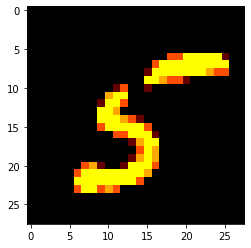

  4%|▍         | 2/50 [00:00<00:07,  6.33it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


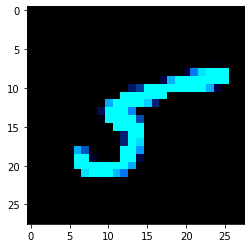

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


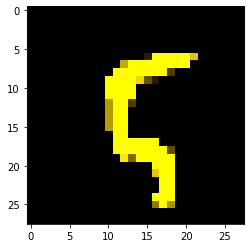

  8%|▊         | 4/50 [00:00<00:04,  9.31it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


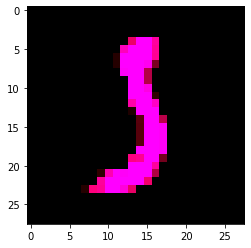

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


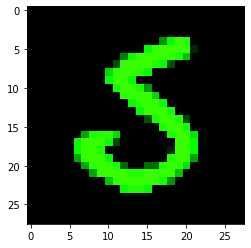

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


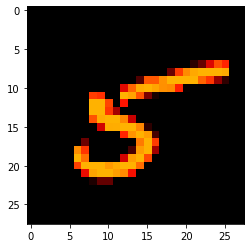

 10%|█         | 5/50 [00:00<00:06,  6.62it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


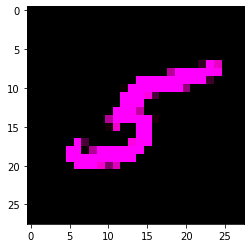

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


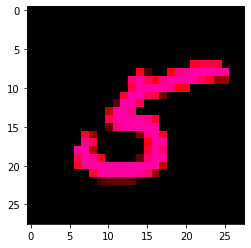

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


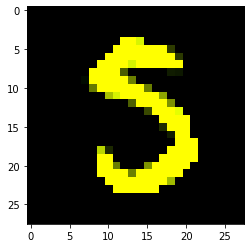

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


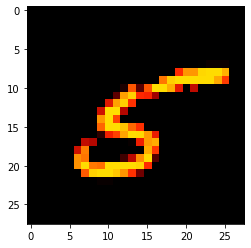

 12%|█▏        | 6/50 [00:01<00:09,  4.70it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


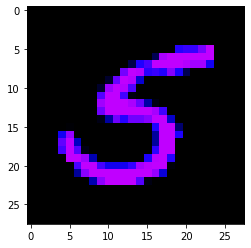

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


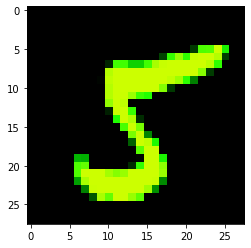

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


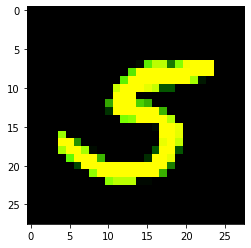

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


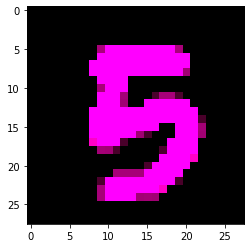

 16%|█▌        | 8/50 [00:01<00:07,  5.32it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


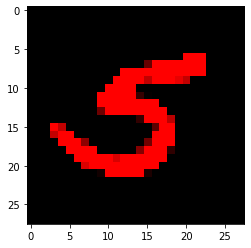

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


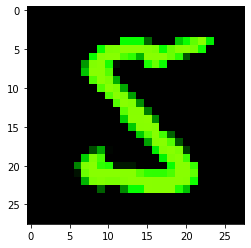

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


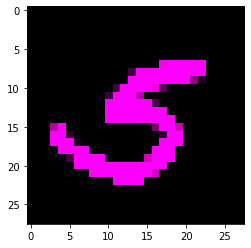

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


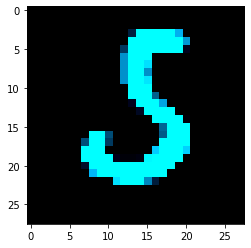

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


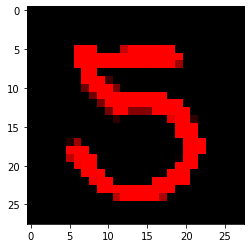

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


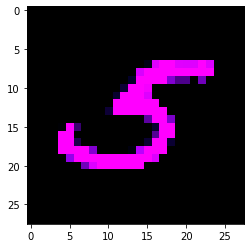

 18%|█▊        | 9/50 [00:01<00:11,  3.56it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


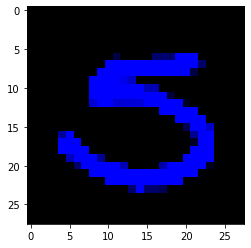

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


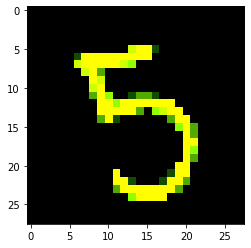

 20%|██        | 10/50 [00:02<00:09,  4.02it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


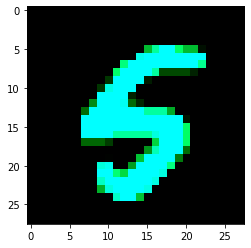

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


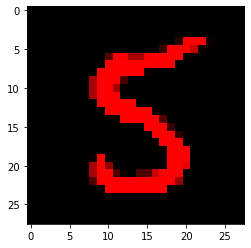

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


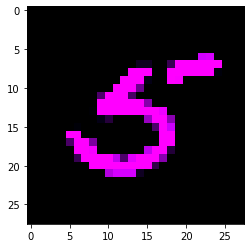

 22%|██▏       | 11/50 [00:02<00:09,  3.95it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


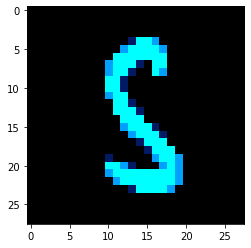

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


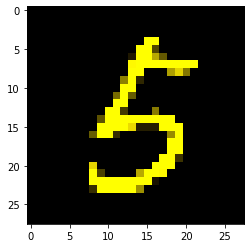

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


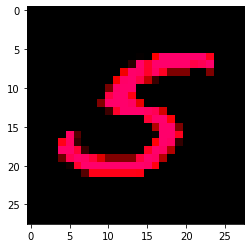

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


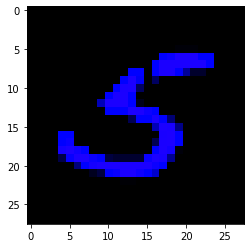

 26%|██▌       | 13/50 [00:02<00:08,  4.19it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


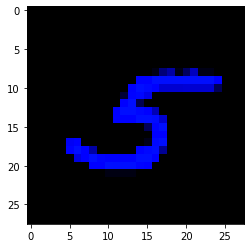

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


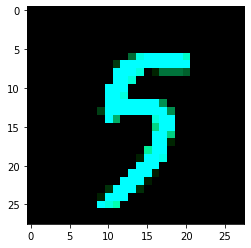

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


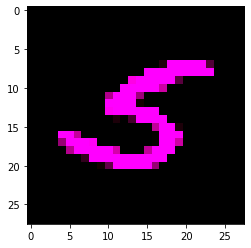

 28%|██▊       | 14/50 [00:03<00:08,  4.09it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


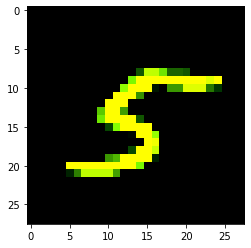

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


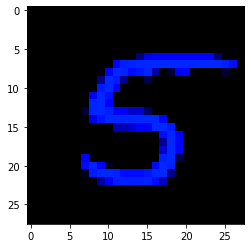

 30%|███       | 15/50 [00:03<00:07,  4.51it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


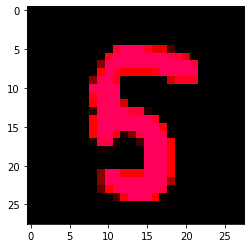

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


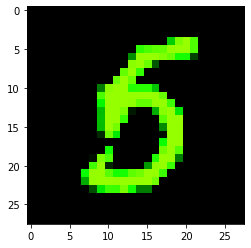

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


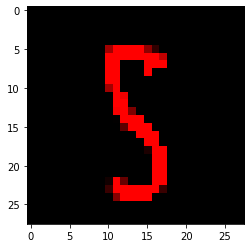

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


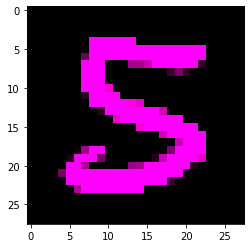

 32%|███▏      | 16/50 [00:03<00:08,  3.96it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


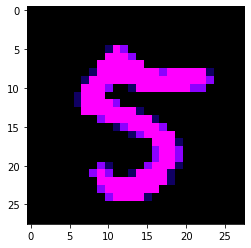

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


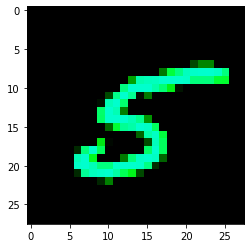

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


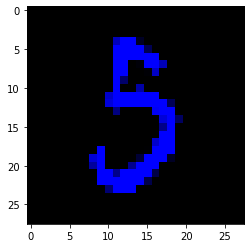

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


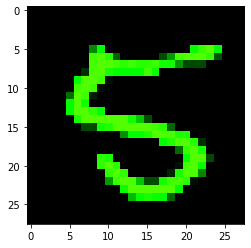

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


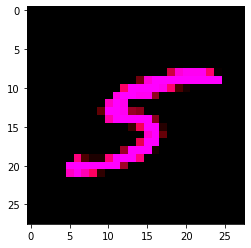

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


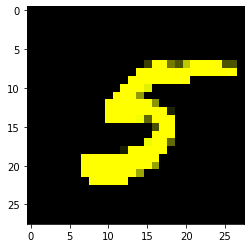

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


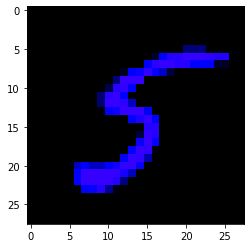

 34%|███▍      | 17/50 [00:04<00:11,  2.90it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


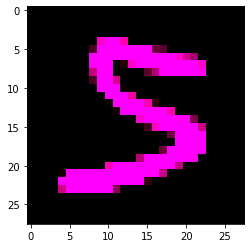

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


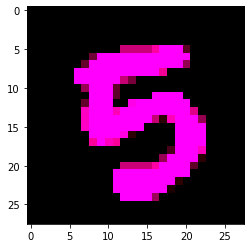

 36%|███▌      | 18/50 [00:04<00:09,  3.44it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


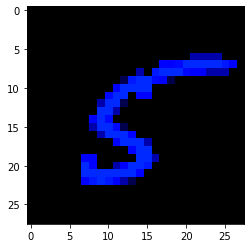

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


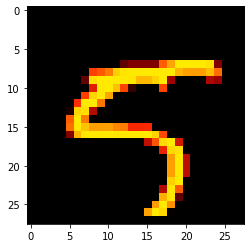

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


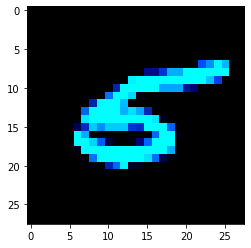

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


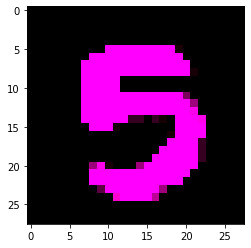

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


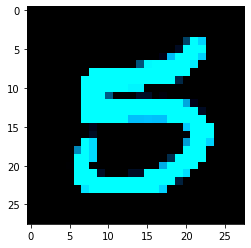

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


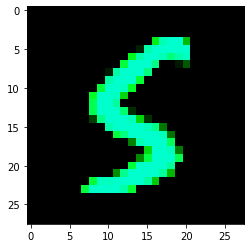

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


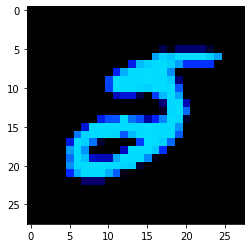

 40%|████      | 20/50 [00:04<00:08,  3.40it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


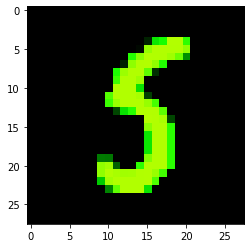

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


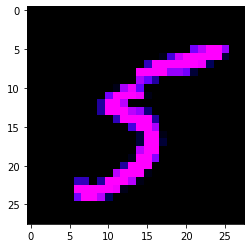

 42%|████▏     | 21/50 [00:05<00:07,  3.84it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


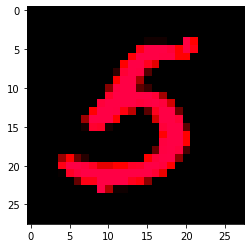

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


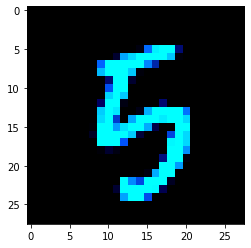

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


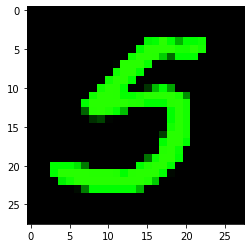

 44%|████▍     | 22/50 [00:05<00:08,  3.49it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


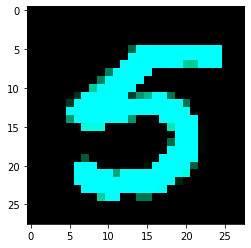

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


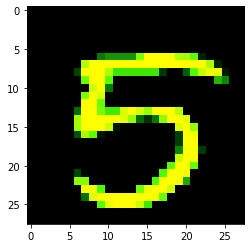

 46%|████▌     | 23/50 [00:05<00:06,  3.91it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


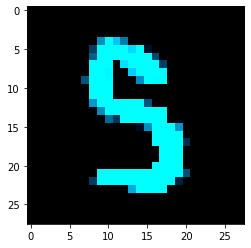

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


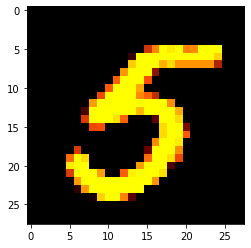

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


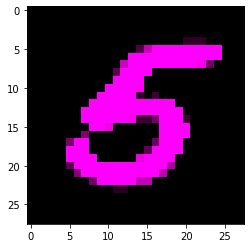

 48%|████▊     | 24/50 [00:05<00:06,  3.87it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


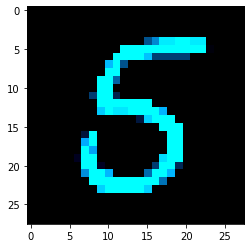

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


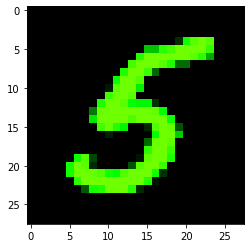

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


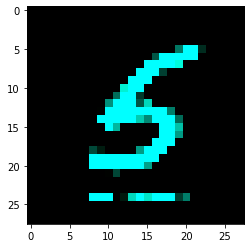

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


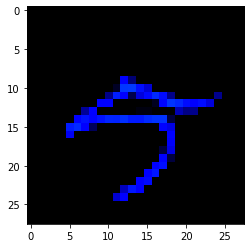

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


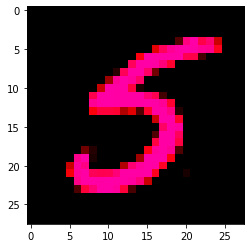

 50%|█████     | 25/50 [00:06<00:07,  3.34it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


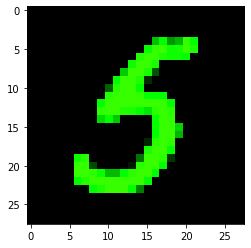

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


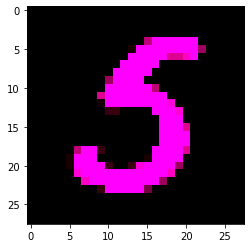

 52%|█████▏    | 26/50 [00:06<00:06,  3.76it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


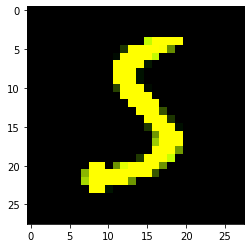

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


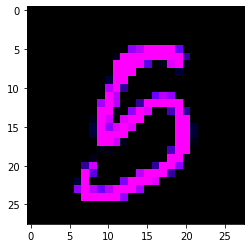

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


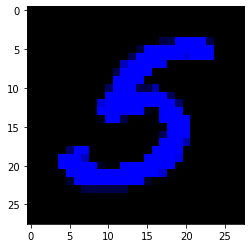

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


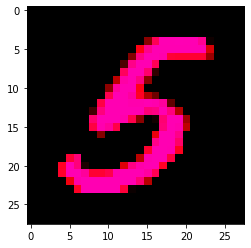

 54%|█████▍    | 27/50 [00:06<00:06,  3.44it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


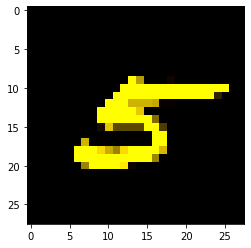

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


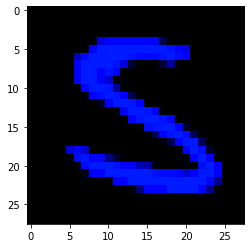

 56%|█████▌    | 28/50 [00:06<00:05,  3.98it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


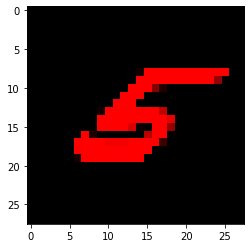

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


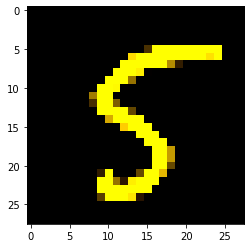

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


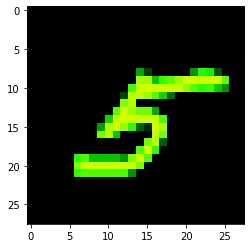

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


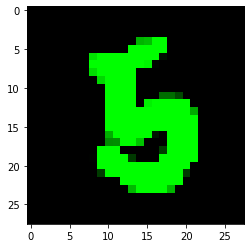

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


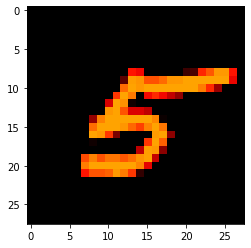

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


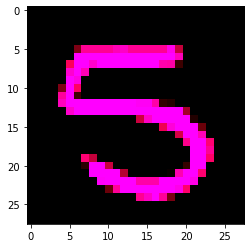

 58%|█████▊    | 29/50 [00:07<00:06,  3.16it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


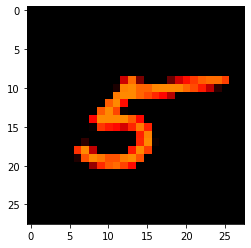

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


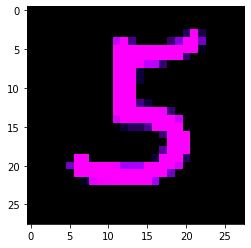

 60%|██████    | 30/50 [00:07<00:05,  3.71it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


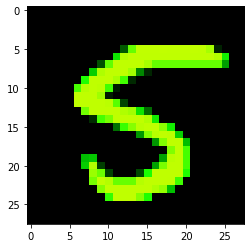

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


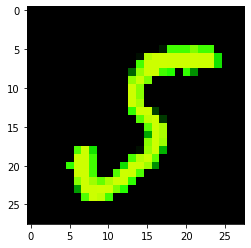

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


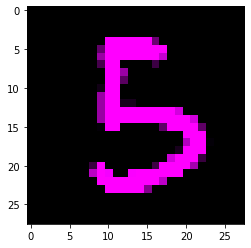

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


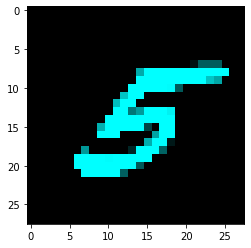

 62%|██████▏   | 31/50 [00:08<00:06,  3.13it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


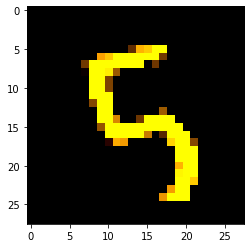

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


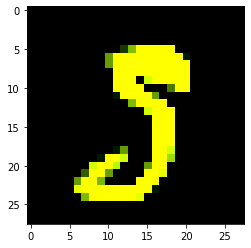

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


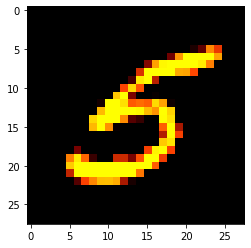

 66%|██████▌   | 33/50 [00:08<00:03,  4.37it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


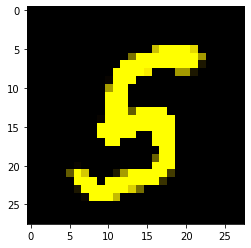

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


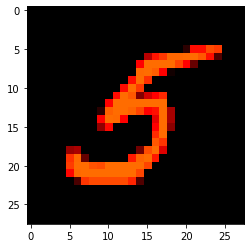

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


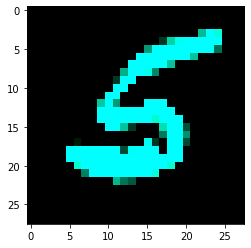

 68%|██████▊   | 34/50 [00:08<00:03,  4.29it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


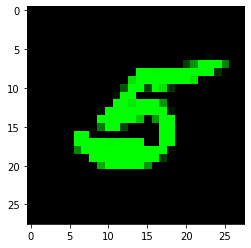

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


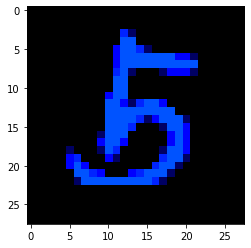

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


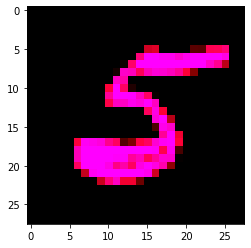

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


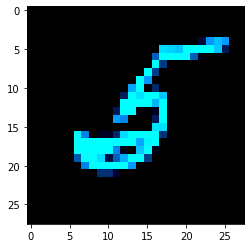

 70%|███████   | 35/50 [00:08<00:03,  3.93it/s]


KeyboardInterrupt: 

In [16]:
count_dict = {}
for i in range(10):
    count_dict[i] = 0
for (images, labels) in tqdm(train_dataloader):
    for i in range(len(images)):
        count_dict[labels[i].item()] += 1
        if labels[i] == 5:
            new_image = images[i]
            plt.imshow(new_image.permute(1, 2, 0))
            plt.show()
        
print(count_dict)